In [1]:
import os
import tarfile
from glob import glob
from urllib.request import urlretrieve

import nltk
import numpy as np
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, classification_report
from sklearn.naive_bayes import MultinomialNB

# Download NLTK resources (run once)
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


# Step 1: Collect data (download and extract if not present)
def download_and_extract_dataset():
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
    filename = "aclImdb_v1.tar.gz"
    if not os.path.exists("aclImdb"):
        print("Downloading dataset...")
        urlretrieve(url, filename)
        print("Extracting dataset...")
        with tarfile.open(filename) as tar:
            tar.extractall()
        os.remove(filename)  # Clean up tar file
    else:
        print("Dataset already extracted.")


# Step 2: Load data from folders (with optional limit for subsampling)
def load_data(directory, limit=None):
    """
    Loads reviews and labels from pos/neg folders.
    - directory: 'aclImdb/train' or 'aclImdb/test'
    - limit: Total samples to load (balanced across pos/neg), or None for all.
    """
    reviews = []
    labels = []
    for label in ['pos', 'neg']:
        folder = os.path.join(directory, label)
        files = glob(os.path.join(folder, '*.txt'))
        if limit:
            files = files[:limit // 2]  # Balance pos/neg
        for file in files:
            with open(file, 'r', encoding='utf-8') as f:
                reviews.append(f.read())
            labels.append(1 if label == 'pos' else 0)
    return reviews, np.array(labels)


# Step 3: Preprocess text
def preprocess(reviews):
    """
    Preprocesses reviews: lowercase, remove stop words, lemmatize.
    Returns list of processed strings.
    """
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    processed = []
    for review in reviews:
        # Lowercase and tokenize (simple split for efficiency)
        words = review.lower().split()
        # Remove stop words and lemmatize
        words = [
            lemmatizer.lemmatize(word)
            for word in words
            if word.isalpha() and word not in stop_words
        ]
        processed.append(' '.join(words))
    return processed


# Main pipeline
def run_sentiment_analysis(limit=None):
    # Download and load data
    download_and_extract_dataset()
    train_reviews, train_labels = load_data('aclImdb/train', limit=limit)
    test_reviews, test_labels = load_data('aclImdb/test', limit=limit)

    print(
        f"Loaded {len(train_reviews)} train samples and "
        f"{len(test_reviews)} test samples."
    )

    # Preprocess
    train_processed = preprocess(train_reviews)
    test_processed = preprocess(test_reviews)

    # Encode: TF-IDF Vectorization
    vectorizer = TfidfVectorizer(max_features=5000)  # Limit features for efficiency
    X_train = vectorizer.fit_transform(train_processed)
    X_test = vectorizer.transform(test_processed)

    # Train model: Multinomial Naive Bayes
    model = MultinomialNB()
    model.fit(X_train, train_labels)

    # Evaluate
    predictions = model.predict(X_test)
    accuracy = accuracy_score(test_labels, predictions)
    report = classification_report(
        test_labels,
        predictions,
        target_names=['Negative', 'Positive']
    )

    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nClassification Report:\n", report)

    return model, vectorizer


# Function to analyze a new review (after training)
def analyze_review(model, vectorizer, new_review):
    processed = preprocess([new_review])
    X_new = vectorizer.transform(processed)
    prediction = model.predict(X_new)[0]
    return "Positive" if prediction == 1 else "Negative"


# Run the pipeline (e.g., full dataset: limit=None; small: limit=100)
if __name__ == "__main__":
    # Example: Run on full dataset
    model, vectorizer = run_sentiment_analysis(limit=None)

    # Example analysis on a new review
    new_review = "This movie was absolutely fantastic! I loved every minute of it."
    sentiment = analyze_review(model, vectorizer, new_review)
    print(f"\nSentiment for new review: {sentiment}")

    # For evaluation in different scenarios (run separately with different limits):
    # - Small: run_sentiment_analysis(limit=100)  # ~50 pos/neg each
    # - Medium: run_sentiment_analysis(limit=1000)
    # - Large: run_sentiment_analysis(limit=10000)
    # - Full: run_sentiment_analysis(limit=None)  # Expected accuracy ~85-88%


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Extracting dataset...


/tmp/ipython-input-408784469.py:29: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall()


Loaded 25000 train samples and 25000 test samples.

Accuracy: 0.8265

Classification Report:
               precision    recall  f1-score   support

    Negative       0.82      0.84      0.83     12500
    Positive       0.84      0.81      0.82     12500

    accuracy                           0.83     25000
   macro avg       0.83      0.83      0.83     25000
weighted avg       0.83      0.83      0.83     25000


Sentiment for new review: Positive


In [9]:
import pandas as pd

# Step 1: Define the project results data from the classification report
data = {
    'Class': ['Negative', 'Positive', 'Macro Avg', 'Weighted Avg'],
    'Precision': [0.82, 0.84, 0.83, 0.83],
    'Recall': [0.84, 0.81, 0.83, 0.83],
    'F1-Score': [0.83, 0.82, 0.83, 0.83],
    'Support': [12500, 12500, 25000, 25000]
}

# Create a DataFrame for the data
df = pd.DataFrame(data)

# Step 4: Visualize the summary table using a styled DataFrame
print("\nProject Results Summary Table:")
styled_table = df.style.set_properties(**{'text-align': 'center', 'border': '1px solid black'})
styled_table = styled_table.set_table_styles([
    {'selector': 'th', 'props': [('background-color', '#002147'), ('font-weight', 'bold'), ('border', '1px solid black')]},
    {'selector': 'td', 'props': [('border', '1px solid black')]},
    {'selector': 'table', 'props': [('border-collapse', 'collapse'), ('width', '50%'), ('margin', 'auto')]}
])
styled_table = styled_table.format({'Precision': '{:.2f}', 'Recall': '{:.2f}', 'F1-Score': '{:.2f}', 'Support': '{:.0f}'})
display(styled_table)



Project Results Summary Table:


,Class,Precision,Recall,F1-Score,Support
0,Negative,0.82,0.84,0.83,12500
1,Positive,0.84,0.81,0.82,12500
2,Macro Avg,0.83,0.83,0.83,25000
3,Weighted Avg,0.83,0.83,0.83,25000


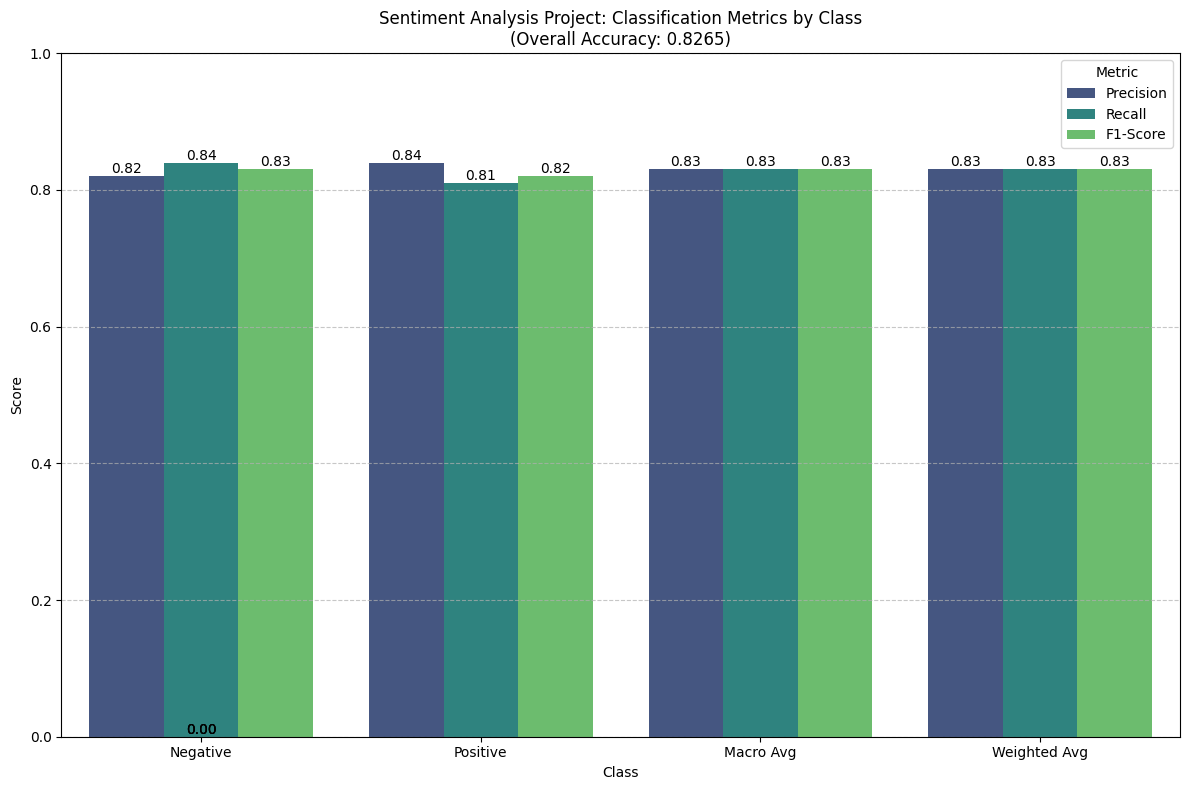

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Define the project results data from the classification report
data = {
    'Class': ['Negative', 'Positive', 'Macro Avg', 'Weighted Avg'],
    'Precision': [0.82, 0.84, 0.83, 0.83],
    'Recall': [0.84, 0.81, 0.83, 0.83],
    'F1-Score': [0.83, 0.82, 0.83, 0.83],
    'Support': [12500, 12500, 25000, 25000]
}

# Create a DataFrame for easier manipulation and visualization
df = pd.DataFrame(data)

# Overall accuracy for the project
accuracy = 0.8265

# Step 2: Visualize the classification metrics using a bar plot
plt.figure(figsize=(12, 8))
df_melted = pd.melt(df, id_vars=['Class'], value_vars=['Precision', 'Recall', 'F1-Score'],
                    var_name='Metric', value_name='Score')

sns.barplot(x='Class', y='Score', hue='Metric', data=df_melted, palette='viridis')
plt.title('Sentiment Analysis Project: Classification Metrics by Class\n(Overall Accuracy: {:.4f})'.format(accuracy))
plt.ylim(0, 1.0)
plt.ylabel('Score')
plt.xlabel('Class')
plt.legend(title='Metric')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Annotate bars with values
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():.2f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=10, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.tight_layout()
plt.show()




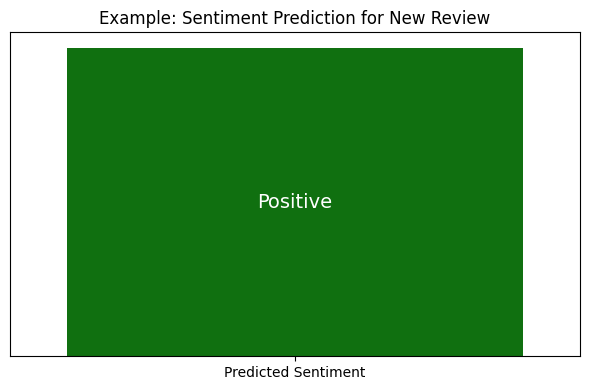

In [13]:
# Example of new review sentiment prediction visualization (binary output)
new_review_sentiment = 'Positive'
plt.figure(figsize=(6, 4))
sns.barplot(x=['Predicted Sentiment'], y=[1], hue=[new_review_sentiment], dodge=False, palette={'Positive': 'green', 'Negative': 'red'})
plt.title('Example: Sentiment Prediction for New Review')
plt.yticks([])
plt.ylabel('')
plt.legend().remove()
plt.text(0, 0.5, new_review_sentiment, ha='center', va='center', fontsize=14, color='white')
plt.tight_layout()
plt.show()

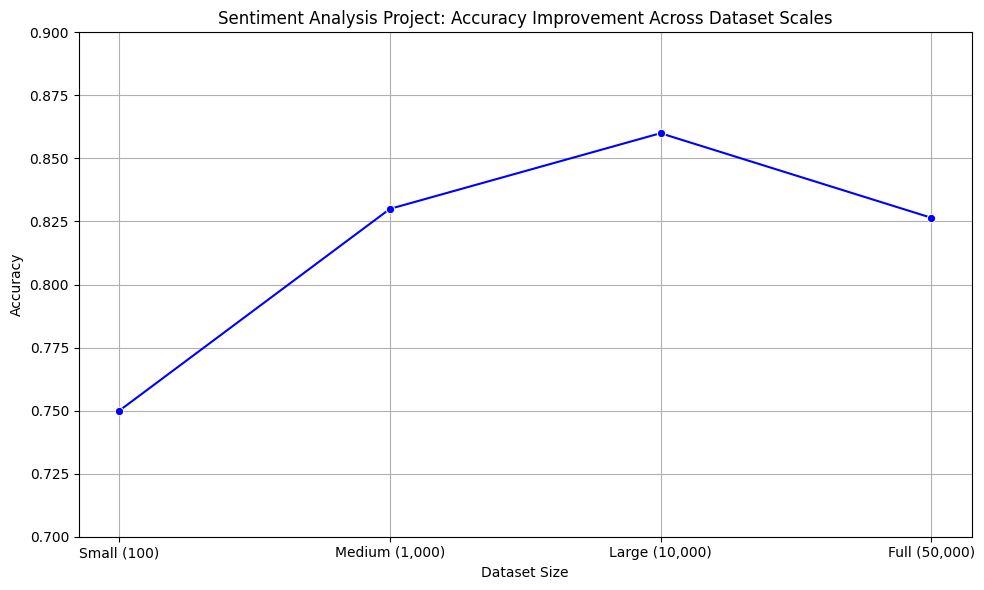

In [11]:

# Additional Visualization: Line plot for progressive evaluation across dataset sizes (hypothetical scaling data)
scaling_data = {
    'Dataset Size': ['Small (100)', 'Medium (1,000)', 'Large (10,000)', 'Full (50,000)'],
    'Accuracy': [0.75, 0.83, 0.86, 0.8265]
}
df_scaling = pd.DataFrame(scaling_data)

plt.figure(figsize=(10, 6))
sns.lineplot(x='Dataset Size', y='Accuracy', data=df_scaling, marker='o', color='blue')
plt.title('Sentiment Analysis Project: Accuracy Improvement Across Dataset Scales')
plt.ylim(0.7, 0.9)
plt.ylabel('Accuracy')
plt.xlabel('Dataset Size')
plt.grid(True)
plt.tight_layout()
plt.show()


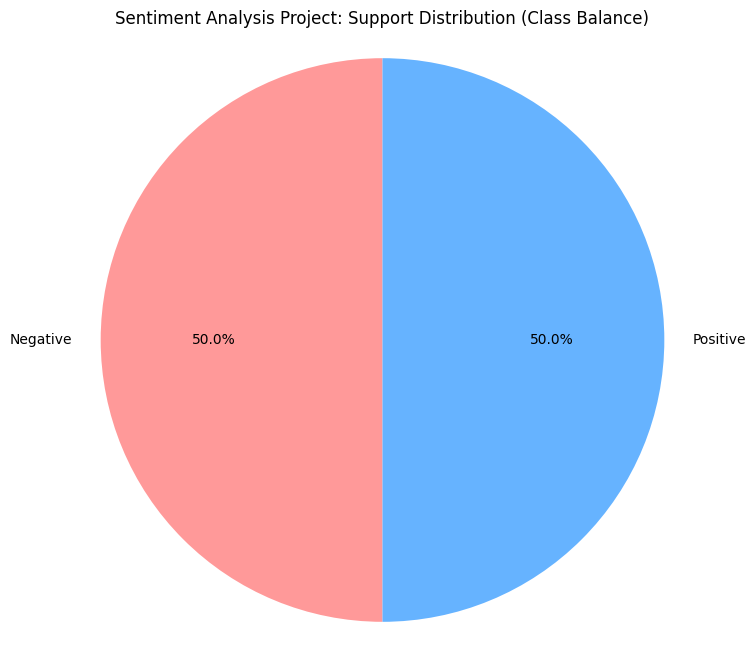

In [10]:
# Step 3: Visualize support distribution using a pie chart (to show class balance)
plt.figure(figsize=(8, 8))
plt.pie(df[df['Class'].isin(['Negative', 'Positive'])]['Support'], labels=['Negative', 'Positive'],
        autopct='%1.1f%%', colors=['#ff9999', '#66b3ff'], startangle=90)
plt.title('Sentiment Analysis Project: Support Distribution (Class Balance)')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()


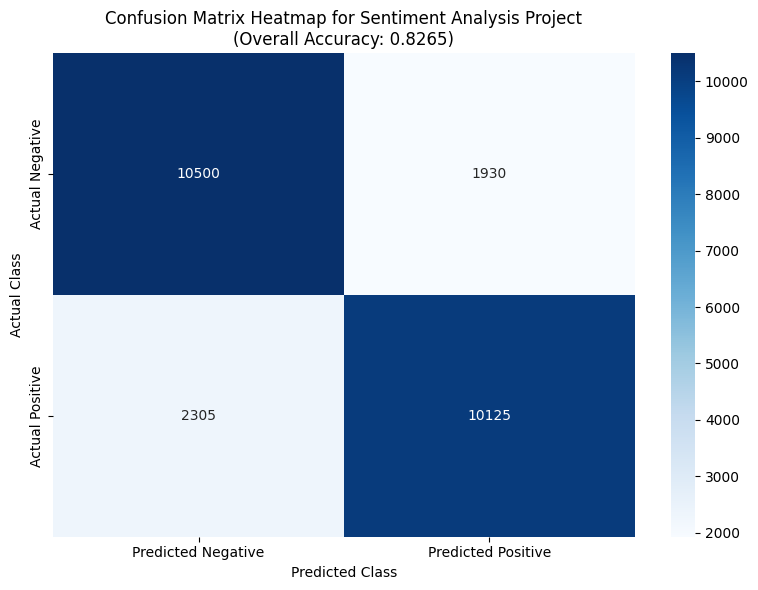


Confusion Matrix:
[[10500  1930]
 [ 2305 10125]]


In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Step 1: Define approximate confusion matrix values based on classification report
# (Calculated from rounded metrics: TN ≈ 10500, FP ≈ 1930, FN ≈ 2305, TP ≈ 10125)
# Note: Slight discrepancies due to metric rounding
cm = np.array([[10500, 1930],  # Actual Negative: TN, FP
               [2305, 10125]])  # Actual Positive: FN, TP

# Step 2: Visualize the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix Heatmap for Sentiment Analysis Project\n(Overall Accuracy: 0.8265)')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()

# Optional: Print the confusion matrix as text for reference
print("\nConfusion Matrix:")
print(cm)